<a href="https://colab.research.google.com/github/aimanismail21/semantic_segmentation/blob/main/A2_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [28]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [29]:
path_lbl = path/'labels'
path_img = path/'images'

In [30]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009870.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08340.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008430.png')]

In [31]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_009510_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_07999_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06270_P.png')]

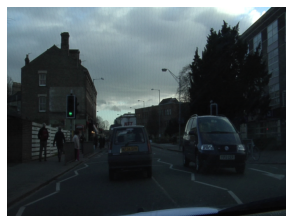

In [32]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [33]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

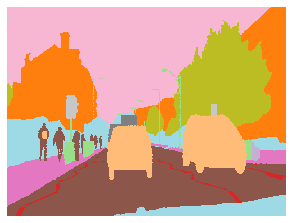

In [34]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [35]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [36]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [38]:
src = (SegmentationItemList.from_folder(path_img) # Create a segmentation data loader object by pasing image path
       .split_by_fname_file('../valid.txt') # Standard 80/20 split for training and validation
       .label_from_func(get_y_fn, classes=codes)) # Specify how to associate the images with each mask

In [39]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

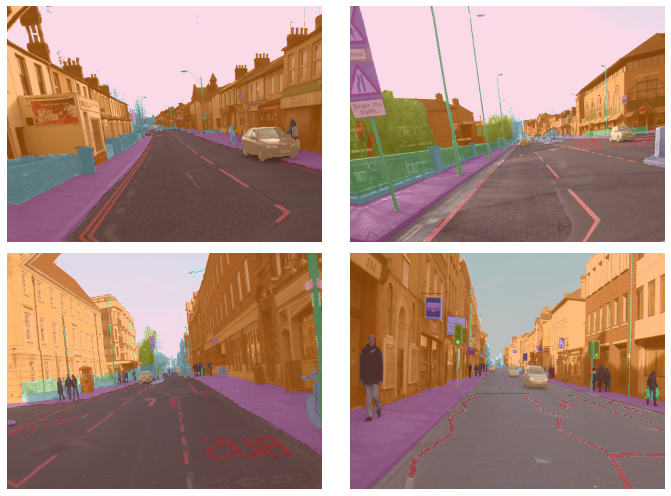

In [40]:
data.show_batch(2, figsize=(10,7))

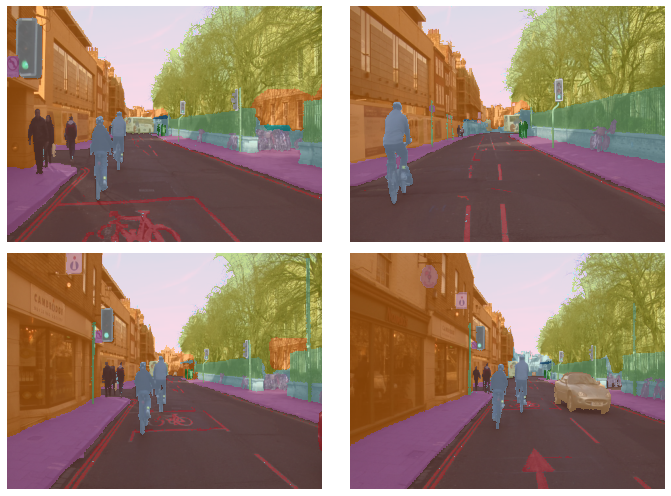

In [41]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [42]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [43]:
# Return Jaccard index, or Intersection over Union (IoU) value
# Sourced from forum user:eckelsjd, name:Joshua Eckels
# Link: https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/2
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [44]:
metrics=[acc_camvid, IoU]
# metrics=accuracy

In [45]:
wd=1e-2 # Weight decay to prevent overfitting.

In [46]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [47]:
learn.load

<bound method Learner.load of Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

epoch,train_loss,valid_loss,acc_camvid,IoU,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


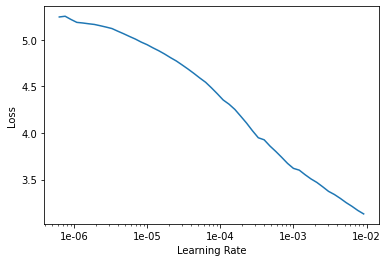

In [48]:
lr_find(learn)
learn.recorder.plot()

In [49]:
lr=3e-3

In [50]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,IoU,time
0,1.311504,0.824741,0.801102,0.109680,01:36
1,0.907693,0.681229,0.837814,0.136003,01:33
2,0.721126,0.565803,0.853825,0.145607,01:33
3,0.637240,0.452855,0.878462,0.177151,01:33
4,0.612580,0.596677,0.856141,0.162333,01:32
5,0.616200,0.525490,0.871008,0.179962,01:32
6,0.603810,0.462788,0.871178,0.185634,01:31
7,0.556526,0.408941,0.885765,0.202349,01:31
8,0.525225,0.397095,0.888854,0.216520,01:30
9,0.448205,0.331611,0.902958,0.229624,01:30


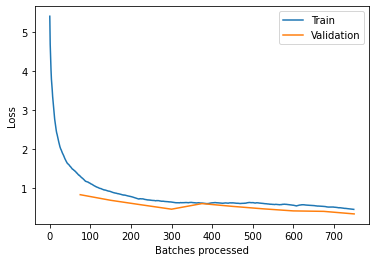

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save('stage-1')

In [53]:
learn.load('stage-1');

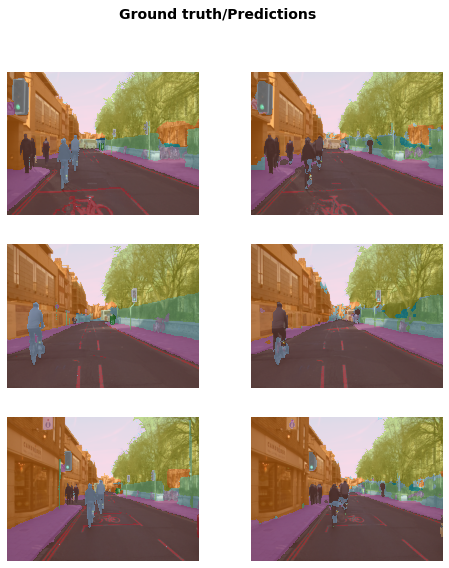

In [54]:
learn.show_results(rows=3, figsize=(8,9))

In [55]:
learn.unfreeze()

In [56]:
lrs = slice(lr/400,lr/4) # Discrimate the learning rate by layer in the NN.

In [57]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,IoU,time
0,0.376198,0.322913,0.904234,0.234750,01:34
1,0.375203,0.313251,0.905428,0.238131,01:34
2,0.365013,0.322533,0.901713,0.236899,01:34
3,0.357015,0.307997,0.908699,0.245263,01:34
4,0.346101,0.285704,0.916819,0.250031,01:34
5,0.332032,0.316907,0.903106,0.246886,01:34
6,0.323411,0.328521,0.904809,0.242191,01:34
7,0.321852,0.278898,0.920441,0.262189,01:34
8,0.302224,0.301166,0.911753,0.254332,01:34
9,0.292910,0.270115,0.924330,0.269783,01:34


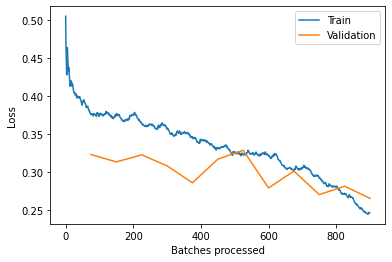

In [58]:
learn.recorder.plot_losses()

In [59]:
learn.save('stage-2');

In [60]:
learn.load('stage-2');

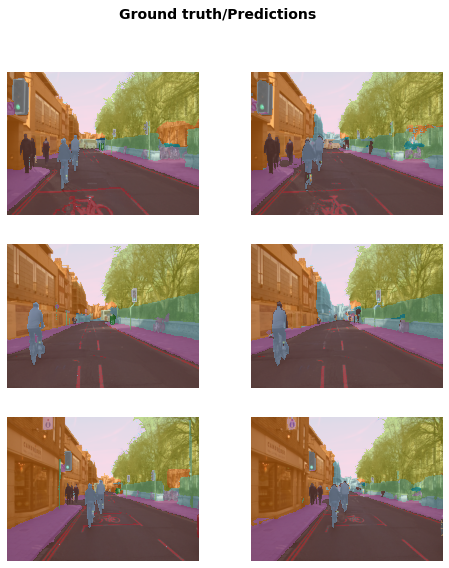

In [61]:
learn.show_results(rows=3, figsize=(8,9))

In [62]:
# To remove used space in jupyter notebook kernel or to restart
# learn.destroy()

# size = src_size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=3
# else:           bs=1
# print(f"using bs={bs}, have {free}MB of GPU RAM free")